# Data Augmentation

In [ ]:
# TODO: plot RMSE after each experiment, alongside the theoretical worst RMSE

# Cross validate the new data
total_data = load_raster("../data/processed/data.tif")
target = load_raster(target_path)
total_data, target = total_data[target.notna()], target[target.notna()]

model = RandomForestRegressor(n_jobs=-1, random_state=42)
scores = cross_validate(model, total_data, target, scoring=scoring, n_jobs=-1)

print(f"Root Mean Squared Error: {scores["Root Mean Squared Error"].mean()}")





# Create a baseline composite from a Sentinel image with the average across 1 year
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error

data_path = "../data/processed/hyperparameter_tuning/data_mean_1.tif"
target_path = "../data/processed/target.tif"

# Create the composite if it does not exist
if not Path(data_path).exists():
    Path(data_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=data_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
    )

# Cross validate a default random forest regressor
from sklearn.ensemble import RandomForestRegressor
from ltm.features import load_raster
from sklearn.model_selection import cross_validate

scorer = make_scorer(root_mean_squared_error)

data = load_raster(data_path)
target = load_raster(target_path)
data, target = data[target.notna()], target[target.notna()]

cv_result = cross_validate(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    data,
    target,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
)
baseline_score = cv_result["test_score"].mean()

print(f"Baseline RMSE: {baseline_score}")

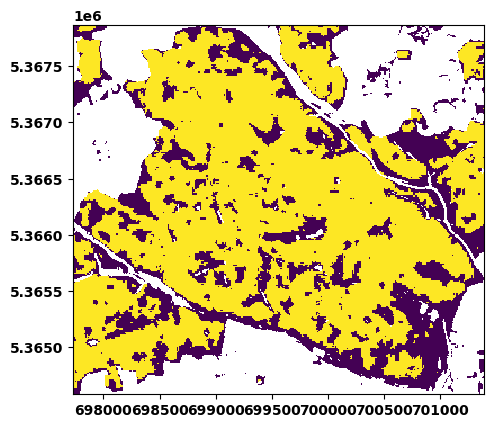

In [12]:
# TODO

# Use unmodified model (2017) to predict area from 2018 and compare result to Dominant Leaf Type Map 2018 (Violin plot for broadleaf and coniferous trees)

from rasterio import MemoryFile
from rasterio.plot import show
from urllib.request import urlopen
import shutil
import numpy as np
import rasterio

geotiff_path = '../data/processed/generalization/Freisinger Forst.tif'

with rasterio.open(geotiff_path) as src:
    crs = src.crs
    bounds = src.bounds
    width = src.width
    height = src.height

url = 'https://copernicus.discomap.eea.europa.eu/arcgis/services/GioLandPublic/HRL_DominanteLeafType_2018/ImageServer/WMSServer'

params = {
     'request': 'GetMap',
     'layers': '0',
     'format': 'image/tiff',
     'width': width,
     'height': height,
     'bbox': ','.join(map(str, bounds)),
     'crs': crs,
}

url = url + '?' + '&'.join([f'{k}={v}' for k, v in params.items()])
tif_bytes = urlopen(url).read()

with MemoryFile(tif_bytes) as memfile:
     with open("tmp.tif", "wb") as out_file:
          shutil.copyfileobj(memfile, out_file)

# Read raster, replace 240 with NaN
with rasterio.open("tmp.tif") as src:
    img = src.read(1).astype(float)
    img[img == 240] = np.nan
    img = img - 1

    profile = src.profile
    profile["dtype"] = rasterio.float32
    profile["nodata"] = np.nan

with rasterio.open("tmp.tif", 'w', **profile) as dst:
    dst.write(img, 1)
    dst.descriptions = ["Conifer"]

with rasterio.open("tmp.tif") as src:
    show(src, interpolation='nearest', cmap='viridis')

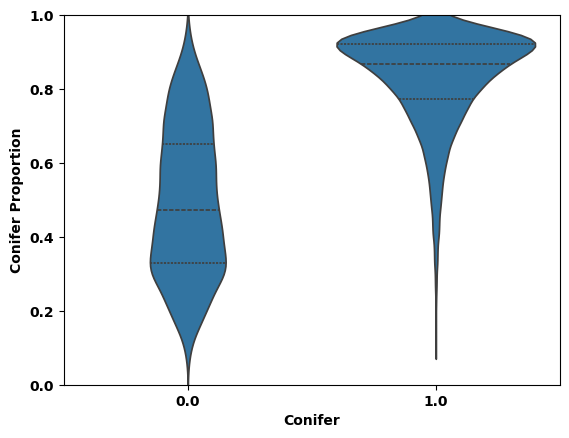

In [14]:
from ltm.features import load_raster

freising = load_raster('tmp.tif')
prediction = load_raster('../data/processed/generalization/Freisinger Forst.tif')

mask = prediction.notna() & freising.notna() & (freising != 240)
freising = freising[mask]
prediction = prediction[mask]

# Plot the violin plot
import seaborn as sns
import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use("science")

ax = sns.violinplot(x=freising, y=prediction, inner="quart")
ax.set_ylim(0, 1)
plt.show()

In [3]:
# TODO

# Plot RMSE throughout all experiments, with following baseline:

# Best RMSE for the target without any information
from sklearn.dummy import DummyRegressor
from ltm.features import load_raster
from sklearn.metrics import make_scorer, root_mean_squared_error

target = load_raster(target_path)
target = target[target.notna()]
data = np.zeros_like(target).reshape(-1, 1)
scorer = make_scorer(root_mean_squared_error)

dummy = DummyRegressor(strategy="mean")
cv_result = cross_validate(dummy, data, target, scoring=scorer, n_jobs=-1)
dummy_score = cv_result["test_score"].mean()
dummy_score

NameError: name 'target_path' is not defined

In [ ]:
# Get optimal composite values
import pandas as pd

df = pd.read_csv("../reports/reducer_composites.csv")
metric = "Root Mean Squared Error"

optimal_idx = df.groupby("Reducer")[metric].idxmin()
optimal_df = df.loc[optimal_idx]
optimal_df = optimal_df.set_index("Reducer")

reducers = [
    "median",
    "mean",
    "mode",
    "min",
    "max",
    "sampleVariance",
    "kendallsCorrelation",
    "skew",
    "kurtosis",
]

optimal_df = optimal_df.loc[reducers]
composite_dict = optimal_df["Composites"].to_dict()

composite_dict = {
    k: v
    for k, v in sorted(composite_dict.items(), key=lambda item: item[1], reverse=True)
}

composite_dict

In [ ]:
# List the optimal bands
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance("../reports/band_importance.csv")

sentinel_bands, indices

In [ ]:
# Define function to create data for one year
from datetime import datetime
from ltm.data import sentinel_composite, split_band_name
from ltm.features import load_raster, interpolate_data, to_float32, save_raster
from pathlib import Path
from time import sleep
from tqdm.notebook import tqdm


def create_data(year, target_path, data_folder, batch_size=None):
    # Skip if data already exists
    stem = Path(data_folder).stem
    data_path = Path(data_folder) / f"{year}/{stem}.tif"
    if data_path.exists():
        return
    data_path.parent.mkdir(parents=True, exist_ok=True)

    # Create one composite for each reducer
    data_path = str(data_path)
    total_data = pd.DataFrame()
    for reducer, num_composites in tqdm(
        composite_dict.items(), desc=f"Downloading Composites for {year}"
    ):
        composite_path = str(
            Path(data_folder) / f"{year}/{stem}_{reducer}_{num_composites}.tif"
        )

        sleep_time = 60
        while not Path(composite_path).exists():
            try:
                sentinel_composite(
                    target_path,
                    composite_path,
                    time_window=(
                        datetime(year, 4, 1),
                        datetime(year + 1, 4, 1),
                    ),
                    num_composites=num_composites,
                    temporal_reducers=[reducer],
                    indices=indices,
                    sentinel_bands=sentinel_bands,
                    batch_size=batch_size,
                )
            except BaseException as e:
                print(e)
                sleep(sleep_time)  # sleep for five minutes
                sleep_time *= 2

    for reducer, num_composites in tqdm(
        composite_dict.items(), desc=f"Combining Composites for {year}"
    ):
        composite_path = str(
            Path(data_folder) / f"{year}/{stem}_{reducer}_{num_composites}.tif"
        )

        # Combine into one raster
        data = load_raster(composite_path)
        data = interpolate_data(data)
        columns = [
            column
            for column in data.columns
            if split_band_name(column)[2:] != ("kendallsCorrelation", "p-value")
        ]
        data = data[columns]
        data = to_float32(data)
        total_data = pd.concat([total_data, data], axis=1)

    # Save the concatenated data
    save_raster(total_data, target_path, data_path)

In [ ]:
# Create data for each year
target_path = "../data/processed/target.tif"
data_folder = "../data/processed/generalization/data/"
years = [2017, 2018, 2019, 2020, 2021, 2022]  # , 2023]

for year in tqdm(years, desc="Years"):
    create_data(year, target_path, data_folder)

# Combine all data into one dataframe
print("Combining data...")
total_data = pd.DataFrame()
for year in tqdm(years, desc="Years"):
    stem = Path(data_folder).stem
    data_path = Path(data_folder) / f"{year}/{stem}.tif"
    data = load_raster(str(data_path))
    total_data = pd.concat([total_data, data])

# Create target data
target = load_raster(target_path)
total_target = pd.concat([target] * len(years))

# Drop rows with NaN label
data, target = (
    total_data[total_target.notna()],
    total_target[total_target.notna()],
)

In [ ]:
# Train best model on new data of the study area
import dill
from sklearn.base import clone

df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
best_model = df["Root Mean Squared Error"].idxmin()

with open(f"../models/{best_model}.pkl", "rb") as f:
    model = dill.load(f)

# Clone model in case warm_start=True and fit on new data
model = clone(model)
model.fit(data, target)

model

# Cross-val predict on seen data

# Prediction on unseen data

In [ ]:
# Create empty target raster from shape with NaN outside of shape
from ltm.data import shapefile2raster
from pathlib import Path

name = "Freisinger Forst"
shapefile_path = f"../data/raw/{name}/{name}.shp"
target_path = f"../data/processed/generalization/{name}.tif"
year = 2023
batch_size = 25  # 25 for Freisinger Forst, 100 for Peterfecking, 200 for Traunstein, None for Brunnstube

Path(target_path).parent.mkdir(parents=True, exist_ok=True)
if not Path(target_path).exists():
    shapefile2raster(
        shapefile_path=shapefile_path,
        raster_path=target_path,
    )

In [ ]:
# Create data for the target area
stem = Path(target_path).stem
data_folder = str(Path(target_path).parent / stem)
create_data(year, target_path, data_folder, batch_size=batch_size)

In [ ]:
# Predict on new data
data_path = str(Path(data_folder) / f"{year}/{stem}.tif")
data = load_raster(data_path)

xgb_pred = model.predict(data)

In [ ]:
# Save the prediction by overwriting the shape raster
import numpy as np
import rasterio

with rasterio.open(target_path) as src:
    profile = src.profile
    shape = src.read().shape
    nan_mask = np.isnan(src.read())

xgb_reshaped = xgb_pred.reshape(shape)

with rasterio.open(target_path, "w", **profile) as dst:
    xgb_reshaped[nan_mask] = np.nan
    dst.write(xgb_reshaped)
    dst.descriptions = ("Conifer Proportion",)

In [ ]:
# Use science style
import matplotlib.pyplot as plt
import scienceplots

%config InlineBackend.figure_format = 'svg'

plt.style.use("science")

In [ ]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

norm = Normalize(vmin=0, vmax=1)
plt.imshow(
    xgb_reshaped.transpose(1, 2, 0),
    cmap="viridis",
    norm=norm,
    interpolation="nearest",
)
plt.colorbar(shrink=0.8)
plt.axis("off")

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

ax = sns.kdeplot(xgb_reshaped.flatten())

plt.show()